In [1]:
import os
import torch
import numpy as np

from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config
from utils.visualize import visualize_pca, visualize_tsne, visualize_kernel



/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = load_yaml_config("configs/sine.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataloader
dl_info = dataloader_info(configs)

Sampling sine-dataset: 100%|██████████| 10000/10000 [00:00<00:00, 16706.59it/s]


In [4]:
# model
model = instantiate_from_config(configs['model']).to(device)

In [5]:
# train
trainer = Trainer(config=configs, model=model, dataloader=dl_info["dataloader"])
trainer.train()

  0%|          | 0/12000 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
loss: 0.098523: 100%|██████████| 12000/12000 [02:04<00:00, 96.43it/s] 


In [6]:
# generate multivariate time-series
dataset = dl_info['dataset']
fake_data = model.generate_mts(batch_size=len(dataset))
np.save(os.path.join(dataset.dir, f'ddpm_fake_sine.npy'), fake_data)

reverse step from x_T to x_0:   0%|          | 0/500 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 500/500 [00:54<00:00,  9.23it/s]


In [7]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))

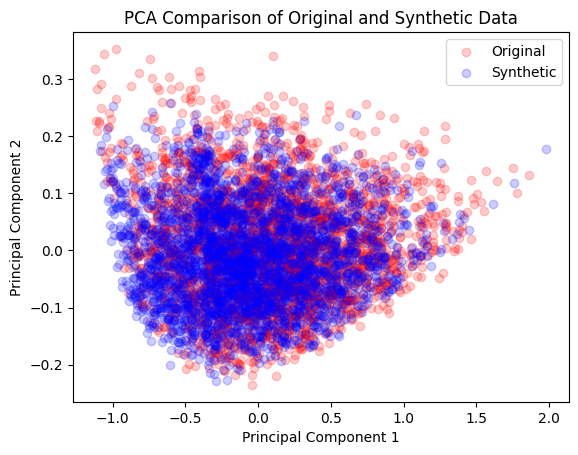

In [8]:
# PCA Analysis
visualize_pca(ori_data, fake_data, n_sample=3000)

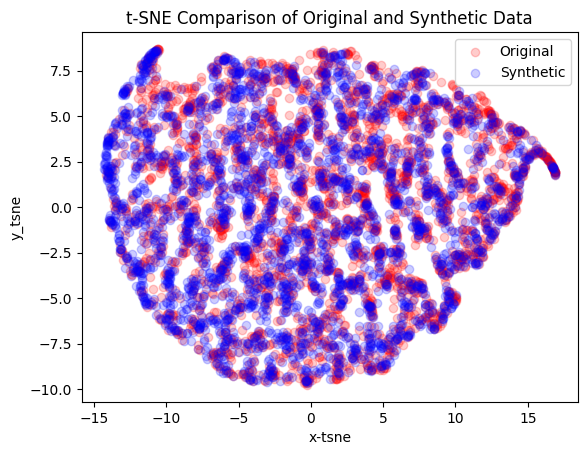

In [9]:
# TSNE Analysis
visualize_tsne(ori_data, fake_data, n_sample=3000)

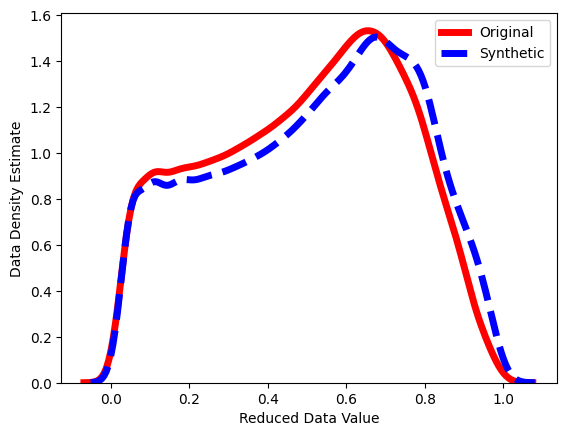

In [10]:
# Kernel Density Plot
visualize_kernel(ori_data, fake_data, n_sample=3000)

In [11]:
# quantatitive metrics
# cross correlation score

from metrics.cross_correlation import CrossCorrelLoss
from utils.utils import display_scores

iterations = 5
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
fake_data = np.load(os.path.join(dataset.dir, f"ddpm_fake_sine.npy"))

In [12]:
def random_choice(size, num_select=100):
    select_idx = np.random.randint(low=0, high=size, size=(num_select,))
    return select_idx

In [13]:
x_real = torch.from_numpy(ori_data)
x_fake = torch.from_numpy(fake_data)

correlational_score = []
size = int(x_real.shape[0] / iterations)

for i in range(iterations):
    real_idx = random_choice(x_real.shape[0], size)
    fake_idx = random_choice(x_fake.shape[0], size)
    corr = CrossCorrelLoss(x_real[real_idx, :, :], name='CrossCorrelLoss')
    loss = corr.compute(x_fake[fake_idx, :, :])
    correlational_score.append(loss.item())
    print(f'Iter {i}: ', 'cross-correlation =', loss.item(), '\n')

display_scores(correlational_score)

Iter 0:  cross-correlation = 0.06424500048160553 

Iter 1:  cross-correlation = 0.061708517372608185 

Iter 2:  cross-correlation = 0.05679283291101456 

Iter 3:  cross-correlation = 0.06291431933641434 

Iter 4:  cross-correlation = 0.06285484880208969 

Final Score: 0.06170 ± 0.00359
